# Single country HLA frequency

In [1]:
import HLAfreq
from HLAfreq import HLAfreq_pymc as HLAhdi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Download AF data
Pick a country to download AF data for. Spaces in country names
are replaced with '+', if in doubt use the allelefrequencies.net
website to search for a country and then check the url for the
appropriate spelling.

In [2]:
country = "Thailand"

base_url = HLAfreq.makeURL(country)
aftab = HLAfreq.getAFdata(base_url)
aftab.to_csv("../data/example/%s_raw.csv" %country, index=False)

5 pages of results
Download complete


## Check completeness
We can't yet combine allele frequency estimates because not all
studies sum to an allele frequency of 1. In this case it is because some studies
reported allele frequencies at 1 field of resolution and we only downloaded
alleles with >2.

To drop incomplete studies use `only_complete()` which will print out the studies
that were incomplete. To view incomplete studies without dropping them use
`incomplete_studies()` before dropping studies.

In [3]:
aftab = HLAfreq.only_complete(aftab)

population          loci
Thailand Northeast  A       0.317
                    B       0.259
                    C       0.245
                    DRB1    0.835
Thailand pop 2      DQA1    0.742
Name: allele_freq, dtype: float64
5 studies have total allele frequency < 0.95


## Check resolution
Because allele frequency estimates can only be combined if the
allele name is identical, all alleles in a set of studies must have
the same resolution i.e. A*01 is 2 digit resolution (or 1 field) and
A*01:01 is 4 digit (or 2 field). These cannot be combined as we
cannot tell whether A*01 is A*01:01, A*01:02 etc. For the same reason
we can decrease the resolution of an allele but we cannot
increase it.

Before combining allele frequency estimates we may have to reduce the
resolution of some alleles. `check_resolution()` will report if all
alleles are at the same resolution and the number of estimates at
each resolution.

`decrease_resolution()` reduces the resolution of all alleles to a
specified level so they can be combined.

In [4]:
HLAfreq.check_resolution(aftab)
aftab = HLAfreq.decrease_resolution(aftab, 2)

2    352
3     21
Name: allele, dtype: int64
Multiple resolutions in AFtab. Fix with decrease_resolution()


## Combine AF from studies
We can only combine allele frequency estimates for a single loci
at a time. So we filter the data to a single loci and then combine
allele frequency estimates using `combineAF()`

In [5]:
afloc = aftab[aftab.loci=="DRB1"]
caf = HLAfreq.combineAF(afloc)

# Calculate High Density interval
# This takes a few seconds and can be skipped if not needed
hdi = HLAhdi.AFhdi(afloc, credible_interval=0.95)
# Add credible intervals and posterior mean to caf
caf = pd.merge(caf, hdi, how="left", on="allele")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


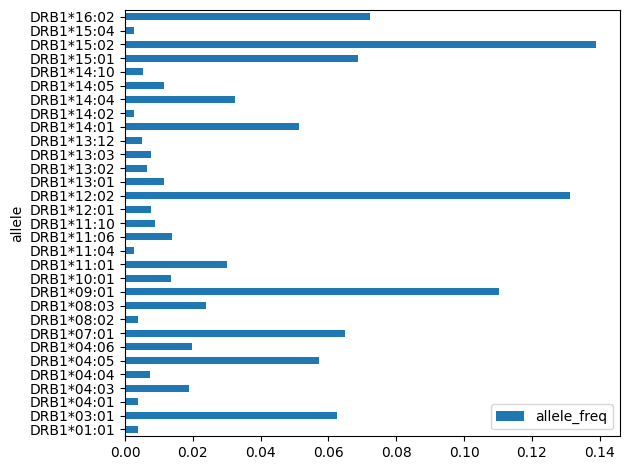

In [7]:
caf.plot.barh('allele', 'allele_freq')
plt.tight_layout()
plt.show()

You can view the combined allele frequency estimates with `plotAF()`. By passing the uncombined allele frequency data we can see the individual study estimates.

The black open points are the combined estimates made using the default model, the coloured points are individual study estimates, coloured by population. The combined estimate and credible intervals from the compound model are plotted as vertical and hoizontal black lines respectively.

The credible intervals are taken from hdi, calculated above. This defaults to 95% but other values can be passed to `AFhdi()` and will be plotted. It is important to verify the credible intervals are reasonable but HLAfreq will print a warning if they are too different from the default estimate. See the [credible_intervals example](https://github.com/Vaccitech/HLAfreq/blob/main/examples/credible_intervals.ipynb) for more details.

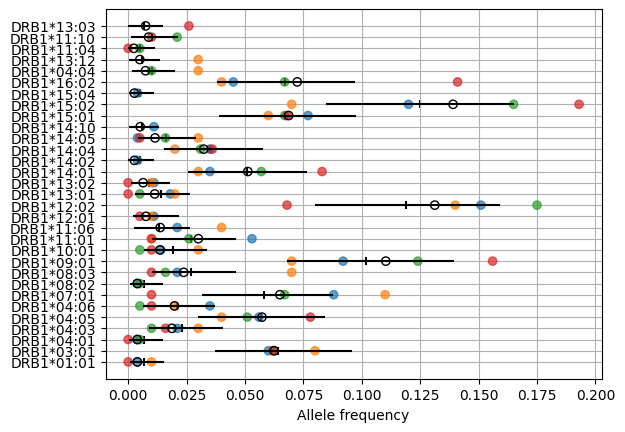

In [8]:
HLAfreq.plotAF(caf, afloc, hdi=hdi, compound_mean=hdi)

## Population coverage
We can calculate and plot the cumulative population coverage of these alleles.
This is calculated with `population_coverage()` which assumes Hardy-Weinberg equilibrium to calculate the population coverage as $p^2+2pq$ where $q=1-p$.

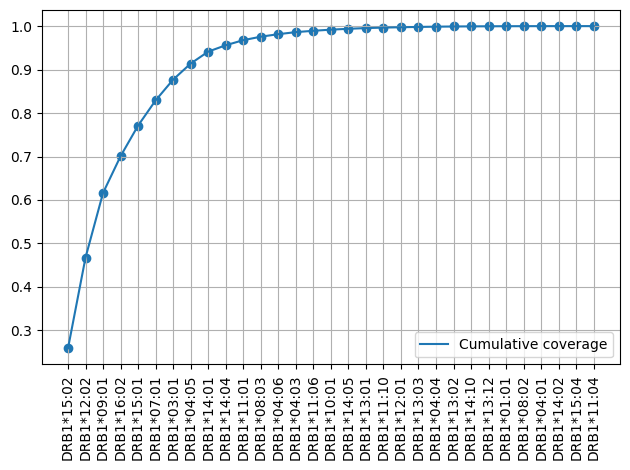

In [9]:
caf = caf.sort_values('allele_freq', ascending=False, ignore_index=True)

plt.scatter(caf.allele, caf.allele_freq.cumsum().apply(HLAfreq.population_coverage))
plt.plot(caf.allele_freq.cumsum().apply(HLAfreq.population_coverage), label="Cumulative coverage")
plt.grid(True)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
